In [1]:
# ======================================
# 1. Install/Import Required Libraries
# ======================================

import pandas as pd
from google_play_scraper import Sort, reviews
import subprocess
from tqdm import tqdm

In [2]:
# ======================================
# 2. Define Parameters
# ======================================

# Package name of the BMW app on Google Play:
app_id = "de.bmw.connected.mobile20.row"

# Ollama model
ollama_model_name = "qwen2.5:latest"

In [3]:
# ======================================
# 3. Fetch Reviews from Google Play Store
# ======================================

# Define languages to fetch (just language codes and labels)
languages = [
    ('en', 'English'),
    ('de', 'German'),
    ('fr', 'French'),
    ('it', 'Italian'),
    ('es', 'Spanish'),
    ('nl', 'Dutch'),
    ('sv', 'Swedish'),
    ('da', 'Danish'),
    ('no', 'Norwegian'),
    ('fi', 'Finnish'),
    ('pl', 'Polish'),
    ('cs', 'Czech'),
    ('pt', 'Portuguese'),
    ('zh', 'Chinese'),
    ('ja', 'Japanese'),
    ('ko', 'Korean'),
    ('ar', 'Arabic'),
    ('tr', 'Turkish'),
    ('ru', 'Russian'),
    ('he', 'Hebrew'),
    ('th', 'Thai'),
    ('vi', 'Vietnamese'),
    ('hi', 'Hindi'),
    ('el', 'Greek'),
    ('hu', 'Hungarian'),
    ('ro', 'Romanian'),
    ('sk', 'Slovak'),
    ('bg', 'Bulgarian'),
    ('hr', 'Croatian'),
    ('sr', 'Serbian'),
    ('uk', 'Ukrainian'),
    ('id', 'Indonesian'),
    ('ms', 'Malay'),
    ('fa', 'Persian'),
    ('ur', 'Urdu'),
    ('bn', 'Bengali'),
    ('ta', 'Tamil'),
    ('te', 'Telugu'),
    ('ml', 'Malayalam'),
    ('et', 'Estonian'),
    ('lv', 'Latvian'),
    ('lt', 'Lithuanian'),
    ('sl', 'Slovenian')
]

# Initialize empty list to store all reviews
all_reviews = []

# Fetch reviews for each language
for lang_code, lang_label in languages:
    continuation_token = None
    prev_length = len(all_reviews)
    
    while True:
        result, continuation_token = reviews(
            app_id,
            lang=lang_code,
            sort=Sort.NEWEST,
            count=100,
            continuation_token=continuation_token
        )
        
        # Add language label to each review
        for review in result:
            review['language'] = lang_label
        
        all_reviews.extend(result)
        
        # Break if no more reviews or if number of reviews isn't increasing
        current_length = len(all_reviews)
        if not continuation_token or current_length - prev_length < 100:
            break
            
        prev_length = current_length

# Convert all reviews into a pandas DataFrame
df = pd.DataFrame(all_reviews)

print("\nReview Statistics:")
print("=" * 50)
print(f"Total number of reviews collected: {len(df)}")
print("\nBreakdown by language:")
print("-" * 50)
language_counts = df['language'].value_counts()
print(language_counts)
print("-" * 50)
print(f"Number of languages with reviews: {len(language_counts)}")
# Inspect the first few rows
df.head()


Review Statistics:
Total number of reviews collected: 17989

Breakdown by language:
--------------------------------------------------
language
German        4836
English       4534
French        1665
Italian       1294
Dutch          948
Spanish        943
Polish         628
Portuguese     565
Russian        466
Romanian       276
Swedish        256
Norwegian      200
Japanese       198
Finnish        172
Czech          155
Greek          115
Hungarian      112
Danish         101
Thai            96
Croatian        64
Turkish         59
Slovak          56
Slovenian       51
Chinese         47
Bulgarian       43
Arabic          31
Serbian         19
Ukrainian       14
Lithuanian      12
Estonian         9
Latvian          7
Indonesian       6
Korean           4
Hebrew           4
Malay            2
Persian          1
Name: count, dtype: int64
--------------------------------------------------
Number of languages with reviews: 36


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,language
0,37d65b2f-f800-4a92-88f2-366c18f17ae3,L Ashman,https://play-lh.googleusercontent.com/a-/ALV-U...,Terrible App! The developer did not consider s...,1,0,5.3.1,2025-03-26 02:08:32,None,NaT,5.3.1,English
1,f3bbe282-ccc0-4511-abfe-bd8ee775f2c8,Tim Jeanes,https://play-lh.googleusercontent.com/a/ACg8oc...,Just doesn't work anymore. once I put in the p...,1,0,5.3.1,2025-03-25 06:27:46,None,NaT,5.3.1,English
2,8f9bfd61-8f15-447e-b454-257931d61c09,Habib Reda,https://play-lh.googleusercontent.com/a-/ALV-U...,it stoped working in saudi arabia ... keeps te...,1,0,5.3.1,2025-03-24 10:21:59,None,NaT,5.3.1,English
3,deea6580-24a0-4ee4-9f12-e43d05b8d58f,Juhana Leinonen,https://play-lh.googleusercontent.com/a-/ALV-U...,It's difficult sometimes to tell if something ...,4,0,5.3.1,2025-03-22 13:20:25,None,NaT,5.3.1,English
4,63b8b20c-18c9-42ed-bdab-d1acfc5b87a5,Nur Arif Mortadza,https://play-lh.googleusercontent.com/a/ACg8oc...,unable to verify on my samsung fold 5,1,0,5.3.1,2025-03-21 17:08:38,None,NaT,5.3.1,English


In [4]:
# ======================================
# 4. Sample Reviews
# ======================================
# After creating the initial DataFrame, add this line to sample 500 random reviews
df2 = df.sample(n=500, random_state=42)  # random_state ensures reproducibility
print(f"Sampled {len(df2)} random reviews for analysis")

Sampled 500 random reviews for analysis


In [5]:
# ======================================
# 5. Translate Non-English Reviews
# ======================================

def translate_text(text, source_lang, ollama_model_name):
    """
    Translate text to English using Ollama.
    
    :param text: Text to translate
    :param source_lang: Source language label (e.g., 'German', 'French')
    :param ollama_model_name: Name of the Ollama model to use
    :return: Translated text
    """
    prompt = f"""You are a professional translator specializing in mobile app reviews. Translate the following {source_lang} BMW app review into fluent, natural English.

Original {source_lang} review: "{text}"

Rules:
1. Preserve the original sentiment and tone completely
2. Maintain technical terms related to BMW vehicles or app features
3. Translate idioms and expressions to their English equivalents
4. Return ONLY the translated text with no explanations, notes, or additional content

English translation:"""
    
    process = subprocess.run(
        ["ollama", "run", ollama_model_name],
        input=prompt,
        text=True,
        capture_output=True
    )
    
    return process.stdout.strip()

# Create a copy of the original content
df2['content_english'] = df2['content']

# Translate non-English reviews
for idx in tqdm(df2[df2['language'] != 'English'].index, desc="Translating reviews"):
    original_text = df2.loc[idx, 'content']
    source_lang = df2.loc[idx, 'language']
    
    translated_text = translate_text(original_text, source_lang, ollama_model_name)
    df2.loc[idx, 'content_english'] = translated_text

# Display a few examples of translated reviews
print("\nExample translations:")
print(df2[['language', 'content', 'content_english']].head(3))

Translating reviews: 100%|██████████| 375/375 [08:57<00:00,  1.43s/it]


Example translations:
     language                                            content  \
4901   German  Update 4.9.2 jetzt aktualisiert sich das Widge...   
7861   German  Es stapeln sich die negativen Bewertungen der ...   
313   English  Please fix charging mode, climatisarion for de...   

                                        content_english  
4901  Update 4.9.2 now the widget no longer updates ...  
7861  The negative reviews for the app are piling up...  
313   Please fix charging mode, climatisarion for de...  


In [8]:
# ======================================
# 6. Display Translation Results
# ======================================

# Set display options to show full content
pd.set_option('display.max_colwidth', None)  # Show full column content
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.width', None)         # Don't wrap to new lines

# Print rows 6000 to 6010 with specified columns
print(df2[['language', 'content', 'content_english']].head(10))

# Reset display options to default (optional)
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')

         language  \
4901       German   
7861       German   
313       English   
6210       German   
15994  Portuguese   
11152     Italian   
10307      French   
8990       German   
12389     Spanish   
8495       German   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        content  \
4901                                                                                                                                                                                                                                                                         

In [35]:
# ======================================
# BMW App Review Analysis - Single Call Version
# ======================================
import time
import subprocess
import pandas as pd
import json
import logging
from tqdm import tqdm
from typing import Dict

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# BMW review topics list
REVIEW_TOPICS = """
1. UI/UX:
   - User interface, app design, ease of use, navigation, overall visual appeal.
2. Performance:
   - App speed, crashes, bugs, stability, battery drain.
3. Connectivity:
   - Connection issues, Bluetooth, server problems, integration with external devices.
4. Authentication:
   - Login issues, account problems, multi-factor authentication, session timeouts.
5. Vehicle Status:
   - Battery, fuel, location, diagnostics.
6. Remote Controls:
   - Lock/unlock, climate control, remote start.
7. Trip Planning:
   - Route optimization, scheduling, and related features.
8. Charging Management:
   - Charging status, locating charging stations, scheduling.
9. Map/Navigation:
   - Maps functionality, route planning, GPS accuracy, alternative route suggestions.
10. Mobile Features:
    - Widgets, notifications, mobile-specific interactions, quick-access features.
11. Data & Privacy:
    - Data handling, privacy concerns, data sharing, security practices.
12. Updates:
    - App updates, version issues, patch notes, update-related bugs.
13. Feature Requests:
    - Desired new functionality, user suggestions for enhancements.
14. Customer Support:
    - Support experience, response time, issue resolution, helpdesk effectiveness.
15. Connected Store:
    - In-app store experience, product browsing, payment process, promotional offers, purchase issues, ease of transaction.
16. BMW Digital Premium:
    - Subscription service experience, access to premium features, content quality, subscription pricing, management of subscription settings.
17. Digital Key/Mobile Key:
    - Phone as key functionality, digital key sharing, key card backup options, access management.
18. Vehicle Configuration & Personalization:
    - Driver profiles, vehicle settings customization, personalized driving modes, saved preferences.
19. Multimedia Integration:
    - Music/entertainment control, Spotify/Apple Music integration, media streaming, audio settings.
20. Smartphone Integration:
    - Apple CarPlay, Android Auto connectivity, screen mirroring, phone-to-vehicle interface.
21. Service & Maintenance:
    - Service scheduling, maintenance alerts, service history tracking, dealer appointment booking.
22. Parking Solutions:
    - Parking location services, parking payment integration, garage/lot availability, last parked location.
23. Voice Assistant:
    - BMW Intelligent Personal Assistant functionality, voice command accuracy, voice control features.
24. My Garage/Vehicle Management:
    - Multi-vehicle support, vehicle profiles, adding/removing vehicles from account.
25. Localization & Language:
    - Translation issues, region-specific feature availability, language support.
26. BMW Connected Ecosystem:
    - Integration with other BMW services, Connected Drive features, BMW ID account.
27. EV-Specific Features:
    - Range prediction, battery optimization, preconditioning, charging schedules for electric BMW vehicles.
"""

def run_ollama(prompt: str, model_name: str) -> str:
    """
    Execute the Ollama model with the provided prompt.
    
    :param prompt: The prompt to send to Ollama.
    :param model_name: The Ollama model name.
    :return: The stdout from the subprocess call or an empty string on error.
    """
    try:
        process = subprocess.run(
            ["ollama", "run", model_name],
            input=prompt,
            text=True,
            capture_output=True,
            check=True
        )
        return process.stdout.strip()
    except subprocess.CalledProcessError as e:
        logging.error("Ollama command failed: %s", e.stderr)
        return ""

def analyze_review_comprehensive(review_text: str, model_name: str) -> Dict:
    """
    Analyze a review with a single API call, returning sentiment, topics, and classifications.
    
    Args:
        review_text (str): The review text to analyze
        model_name (str): Name of the Ollama model to use
    
    Returns:
        Dict: Complete analysis results in JSON format
    """
    prompt = f"""You are an expert BMW app review analyzer with specialized knowledge in automotive apps. Analyze the following BMW app review comprehensively.

BMW App Review: "{review_text}"

ANALYSIS TASKS:

1. SENTIMENT ANALYSIS:
   Determine the overall sentiment (must be exactly one of: positive, negative, neutral)
   - Positive: User expresses satisfaction, appreciation, praise, or happiness with the app
   - Negative: User expresses dissatisfaction, frustration, criticism, or problems with the app
   - Neutral: User provides balanced feedback or states facts without clear positive/negative emotion
   
   For mixed reviews with both positive and negative elements:
   - If negative aspects clearly outweigh positive ones, classify as "negative"
   - If positive aspects clearly outweigh negative ones, classify as "positive"
   - If roughly balanced, classify as "neutral"
   - Focus on the most recent experience if the review describes changes over time

2. TOPIC IDENTIFICATION:
   Identify 1-5 most relevant topics from this list:
{REVIEW_TOPICS}

3. BINARY CLASSIFICATIONS:
   For each classification below, determine if the criteria are met (must be exactly "yes" or "no"):

   a) IS_PAIN_POINT:
      Answer "yes" if ANY of these criteria are met:
      - User mentions bugs, glitches, crashes, or technical issues
      - User describes something not working as expected
      - User expresses frustration or difficulty using features
      - User complains about poor performance or design
      - User mentions that app is hard to use or understand
      - User reports connection failures or synchronization problems
      - User describes errors, unexpected behavior, or functionality failures
      Otherwise, answer "no".

   b) IS_FEATURE_REQUEST:
      Answer "yes" if ANY of these criteria are met:
      - User explicitly asks for new functionality
      - User suggests improvements to existing features
      - User mentions "would be nice to have" or similar phrasing
      - User compares to another app's feature they want implemented
      - User describes functionality that doesn't exist but they want
      - User says "please add" or "should include" followed by a feature
      - User expresses desire for missing capabilities
      Otherwise, answer "no".

   c) IS_COMPETITOR_MENTIONED:
      Answer "yes" if ANY of these criteria are met:
      - User mentions other car brands (Mercedes, Audi, Tesla, Porsche, Volkswagen, etc.)
      - User compares BMW app to apps from other manufacturers
      - User mentions switching to/from another car brand because of the app
      - User references features in competitor apps
      - User mentions specific models from other brands
      Otherwise, answer "no".

RESPONSE FORMAT:
Return ONLY a JSON object with exactly this structure:
{{
    "sentiment": "positive/negative/neutral",
    "topics": "Topic1, Topic2, Topic3",
    "classifications": {{
        "is_pain_point": "yes/no",
        "is_feature_request": "yes/no",
        "is_competitor_mentioned": "yes/no"
    }}
}}

CRITICAL RULES:
- Use lowercase for sentiment and classification answers
- Use exact topic names from the provided list
- Include "Other" if topics are unclear
- Return ONLY the JSON with no explanations or additional text
- Answer all classifications as either "yes" or "no" (lowercase)
- For very short or unclear reviews, default to "neutral" sentiment and "Other" topic
- Interpret sarcasm and figurative language based on the actual intent
- Ensure all three classification questions are answered regardless of review length

EXAMPLES:
1. "The app keeps crashing whenever I try to check my car's status. Please fix this!"
   {{
     "sentiment": "negative",
     "topics": "Performance, Vehicle Status",
     "classifications": {{
       "is_pain_point": "yes",
       "is_feature_request": "no",
       "is_competitor_mentioned": "no"
     }}
   }}

2. "Love the new design! Would be great if you could add the ability to schedule charging times."
   {{
     "sentiment": "positive",
     "topics": "UI/UX, Charging Management, Feature Requests",
     "classifications": {{
       "is_pain_point": "no",
       "is_feature_request": "yes",
       "is_competitor_mentioned": "no"
     }}
   }}

Analyze the review and respond with the JSON:"""


    # Default response in case of failure
    default_response = {
        "sentiment": "neutral",
        "topics": "Other",
        "classifications": {
            "is_pain_point": "No",
            "is_feature_request": "No",
            "is_competitor_mentioned": "No"
        }
    }

    try:
        response = run_ollama(prompt, model_name)
        # Find JSON in response (in case model includes any extra text)
        json_start = response.find('{')
        json_end = response.rfind('}') + 1
        if json_start >= 0 and json_end > 0:
            result = json.loads(response[json_start:json_end])
            # Validate and normalize the response
            return {
                "sentiment": result.get("sentiment", "neutral").capitalize(),
                "topics": result.get("topics", "Other"),
                "classifications": {
                    "is_pain_point": result.get("classifications", {}).get("is_pain_point", "No"),
                    "is_feature_request": result.get("classifications", {}).get("is_feature_request", "No"),
                    "is_competitor_mentioned": result.get("classifications", {}).get("is_competitor_mentioned", "No")
                }
            }
        return default_response
    except Exception as e:
        logging.error(f"Analysis failed: {str(e)}")
        return default_response

def analyze_reviews_all(df: pd.DataFrame, model_name: str, batch_size: int = 100) -> pd.DataFrame:
    """
    Process ALL reviews with single-call analysis, with optional batching for progress tracking
    and checkpoint saving.
    
    Args:
        df (pd.DataFrame): DataFrame containing reviews with 'content_english' column
        model_name (str): Name of the Ollama model to use
        batch_size (int): Size of batches to process for progress tracking
    
    Returns:
        pd.DataFrame: DataFrame with added analysis columns
    """
    # Create a working copy of the entire DataFrame
    working_df = df.copy()
    total_reviews = len(working_df)
    
    # Initialize results column
    working_df['analysis_results'] = None
    
    # Process in batches for better progress tracking
    logging.info(f"Analyzing all {total_reviews} reviews...")
    
    for start_idx in range(0, total_reviews, batch_size):
        end_idx = min(start_idx + batch_size, total_reviews)
        batch_indices = working_df.index[start_idx:end_idx]
        
        logging.info(f"Processing batch {start_idx//batch_size + 1}/{(total_reviews-1)//batch_size + 1} (reviews {start_idx+1}-{end_idx})")
        
        for idx in tqdm(batch_indices, desc=f"Batch {start_idx//batch_size + 1}"):
            review_text = working_df.loc[idx, 'content_english']
            results = analyze_review_comprehensive(review_text, model_name)
            working_df.at[idx, 'analysis_results'] = results
            time.sleep(0.1)  # Rate limiting
        
        # Save checkpoint after each batch (optional)
        # working_df.to_csv(f"bmw_reviews_analysis_checkpoint_{start_idx}.csv", index=False)
        
        # Print interim stats after each batch
        batch_df = working_df.loc[batch_indices]
        analyzed_count = batch_df['analysis_results'].notna().sum()
        logging.info(f"Batch complete: {analyzed_count}/{len(batch_indices)} reviews analyzed")
    
    # Extract results into separate columns
    logging.info("Extracting results into individual columns...")
    working_df['sentiment'] = working_df['analysis_results'].apply(lambda x: x['sentiment'] if isinstance(x, dict) else 'Neutral')
    working_df['topics'] = working_df['analysis_results'].apply(lambda x: x['topics'] if isinstance(x, dict) else 'Other')
    working_df['is_pain_point'] = working_df['analysis_results'].apply(lambda x: x['classifications']['is_pain_point'] if isinstance(x, dict) else 'No')
    working_df['is_feature_request'] = working_df['analysis_results'].apply(lambda x: x['classifications']['is_feature_request'] if isinstance(x, dict) else 'No')
    working_df['is_competitor_mentioned'] = working_df['analysis_results'].apply(lambda x: x['classifications']['is_competitor_mentioned'] if isinstance(x, dict) else 'No')
    
    return working_df

# Main execution
if __name__ == "__main__":
    try:
        # Verify df2 exists and has required column
        if 'content_english' not in df2.columns:
            raise ValueError("DataFrame must contain 'content_english' column")
        
        # Run analysis on ALL reviews
        logging.info(f"Starting analysis of all {len(df2)} reviews...")
        start_time = time.time()
        
        # Run the full analysis
        df2 = analyze_reviews_all(df2, ollama_model_name)
        
        # Calculate and log total time
        total_time = time.time() - start_time
        hours, remainder = divmod(total_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        logging.info(f"Analysis complete! Total time: {int(hours)}h {int(minutes)}m {int(seconds)}s")
        
        # Save the complete results
        df2.to_csv("bmw_reviews_complete_analysis.csv", index=False)
        logging.info("Results saved to bmw_reviews_complete_analysis.csv")
        
        # Display results
        display_columns = ['content_english', 'sentiment', 'topics', 
                         'is_pain_point', 'is_feature_request', 'is_competitor_mentioned']
        
        print("\n=== Review Analysis Results Sample ===")
        print(df2[display_columns].head())
        
        # Summary statistics
        print("\n=== Summary Statistics ===")
        print(f"Total reviews analyzed: {len(df2)}")
        print("\nSentiment Distribution:")
        print(df2['sentiment'].value_counts())
        print("\nMost Common Topics:")
        all_topics = [topic.strip() for topics in df2['topics'].str.split(',') for topic in topics if isinstance(topics, str)]
        topic_counts = pd.Series(all_topics).value_counts()
        print(topic_counts.head(10))
        print("\nBinary Classifications:")
        print(f"Pain points identified: {(df2['is_pain_point'] == 'Yes').sum()} ({(df2['is_pain_point'] == 'Yes').sum()/len(df2)*100:.1f}%)")
        print(f"Feature requests identified: {(df2['is_feature_request'] == 'Yes').sum()} ({(df2['is_feature_request'] == 'Yes').sum()/len(df2)*100:.1f}%)")
        print(f"Competitor mentions identified: {(df2['is_competitor_mentioned'] == 'Yes').sum()} ({(df2['is_competitor_mentioned'] == 'Yes').sum()/len(df2)*100:.1f}%)")
        
    except Exception as e:
        logging.error(f"Analysis failed: {str(e)}")
        raise

2025-03-28 12:10:10,832 - INFO - Starting analysis of all 500 reviews...
2025-03-28 12:10:10,848 - INFO - Analyzing all 500 reviews...
2025-03-28 12:10:10,849 - INFO - Processing batch 1/5 (reviews 1-100)
Batch 1: 100%|██████████| 100/100 [13:41<00:00,  8.22s/it]
2025-03-28 12:23:52,610 - INFO - Batch complete: 100/100 reviews analyzed
2025-03-28 12:23:52,612 - INFO - Processing batch 2/5 (reviews 101-200)
Batch 2: 100%|██████████| 100/100 [44:52<00:00, 26.93s/it]  
2025-03-28 13:08:45,448 - INFO - Batch complete: 100/100 reviews analyzed
2025-03-28 13:08:45,449 - INFO - Processing batch 3/5 (reviews 201-300)
Batch 3: 100%|██████████| 100/100 [21:31<00:00, 12.92s/it] 
2025-03-28 13:30:17,408 - INFO - Batch complete: 100/100 reviews analyzed
2025-03-28 13:30:17,409 - INFO - Processing batch 4/5 (reviews 301-400)
Batch 4: 100%|██████████| 100/100 [13:09<00:00,  7.89s/it]
2025-03-28 13:43:26,667 - INFO - Batch complete: 100/100 reviews analyzed
2025-03-28 13:43:26,668 - INFO - Processing 


=== Review Analysis Results Sample ===
                                         content_english sentiment  \
4901   Update 4.9.2 now the widget no longer updates ...  Negative   
7861   The negative reviews for the app are piling up...  Negative   
313    Please fix charging mode, climatisarion for de...  Negative   
6210   For a premium brand like BMW, this is disappoi...  Negative   
15994  The app is good. However, maintenance bookings...  Negative   

                                        topics is_pain_point  \
4901                Charging Management, UI/UX           yes   
7861                 Performance, Connectivity           yes   
313       Charging Management, Remote Controls           yes   
6210               Authentication, Performance           yes   
15994  Service & Maintenance, Feature Requests           yes   

      is_feature_request is_competitor_mentioned  
4901                  no                      no  
7861                  no                      no  
3

In [36]:
print("\nFirst 5 rows of df2:")
print(df2.head())


First 5 rows of df2:
                                   reviewId        userName  \
4901   a35692f1-b1f5-4d06-86ed-38108faa5bd4  Matthias Fenzl   
7861   03d5e10d-33b1-4f92-bb3b-fc94e55d33e1            d pa   
313    297b9476-3feb-48a5-9a7d-853e92685a70  Srgjan Akshikj   
6210   7b85d252-b498-431d-be99-0a3f4203c092        Jo Franz   
15994  1b941746-106d-4eea-af3a-49cf53c576b6     Hugo Santos   

                                               userImage  \
4901   https://play-lh.googleusercontent.com/a/ACg8oc...   
7861   https://play-lh.googleusercontent.com/a/ACg8oc...   
313    https://play-lh.googleusercontent.com/a-/ALV-U...   
6210   https://play-lh.googleusercontent.com/a-/ALV-U...   
15994  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                                 content  score  \
4901   Update 4.9.2 jetzt aktualisiert sich das Widge...      1   
7861   Es stapeln sich die negativen Bewertungen der ...      1   
313    Please fix charging mode, clim

In [53]:
from IPython.display import HTML, display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import subprocess
from tqdm.notebook import tqdm

def create_topic_cards_from_df2(df2, ollama_model_name):
    """
    Create visual topic summary cards based on topics already present in df2 with improved aesthetics.
    
    Args:
        df2: DataFrame containing reviews with topics column
        ollama_model_name: Name of the Ollama model to use
    """
    # Check if topics column exists in df2
    if 'topics' not in df2.columns:
        print("Error: 'topics' column not found in df2.")
        print("Available columns:", df2.columns.tolist())
        print("Please run analyze_reviews_all first.")
        return None
    
    # Extract all unique topics
    all_topics = []
    for topic_list in df2['topics']:
        if isinstance(topic_list, str):  # Check if it's a string to avoid errors
            topics = [t.strip() for t in topic_list.split(',')]
            all_topics.extend(topics)
    
    # Count topic frequencies and get unique topics
    topic_counts = pd.Series(all_topics).value_counts()
    unique_topics = topic_counts.index.tolist()
    
    print(f"Found {len(unique_topics)} unique topics in df2.")
    print("Top 10 topics by frequency:")
    print(topic_counts.head(10))
    
    # Setup NLTK resources
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
        nltk.download('punkt')
    
    stop_words = set(stopwords.words('english'))
    custom_stops = {'app', 'bmw', 'car', 'please', 'would', 'also', 'get', 'use', 'using'}
    stop_words.update(custom_stops)
    
    # Generate summaries for each topic
    topic_summaries = {}
    
    # Process top N topics
    top_n_topics = 15
    topics_to_process = topic_counts.head(top_n_topics).index.tolist()
    
    for topic in tqdm(topics_to_process, desc="Processing Topics"):
        # Skip 'Other' category
        if topic.lower() == 'other':
            continue
            
        # Get reviews for this topic
        topic_reviews = df2[df2['topics'].str.contains(topic, na=False)]
        
        if len(topic_reviews) == 0:
            continue
            
        # Calculate statistics
        avg_rating = topic_reviews['score'].mean() if 'score' in topic_reviews.columns else None
        
        # Get sentiment distribution
        sentiment_dist = topic_reviews['sentiment'].value_counts(normalize=True).to_dict()
        
        # Sample reviews for LLM analysis - use content_english column
        content_field = 'content_english' if 'content_english' in topic_reviews.columns else 'content'
        
        if content_field not in topic_reviews.columns:
            print(f"Warning: Neither 'content_english' nor 'content' column found for topic {topic}")
            continue
            
        # Sample up to 10 reviews for analysis
        sampled_reviews = topic_reviews.sample(min(10, len(topic_reviews)))
        review_texts = sampled_reviews[content_field].tolist()
        
        # Extract keywords for this topic
        all_text = " ".join(topic_reviews[content_field].fillna("").tolist()).lower()
        
        # Clean and tokenize
        words = word_tokenize(all_text)
        filtered_words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]
        
        # Get most common words
        word_counts = Counter(filtered_words).most_common(15)
        top_keywords = [word for word, count in word_counts]
        
        # Find common bigrams/phrases
        text_tokens = [t.lower() for t in word_tokenize(all_text) if t.isalpha()]
        bigrams = list(zip(text_tokens, text_tokens[1:]))
        filtered_bigrams = [f"{b[0]} {b[1]}" for b in bigrams 
                           if b[0] not in stop_words and b[1] not in stop_words]
        
        # Get most common bigrams
        bigram_counts = Counter(filtered_bigrams).most_common(10)
        top_bigrams = [bigram for bigram, count in bigram_counts]
        
        # Format rating info for prompt
        if 'score' in topic_reviews.columns:
            rating_counts = topic_reviews['score'].value_counts().sort_index()
            rating_info = f"- Average Rating: {avg_rating:.2f}/5.0 from {len(topic_reviews)} reviews\n- Rating Distribution: {dict(rating_counts)}"
        else:
            rating_info = f"- Total Reviews: {len(topic_reviews)}"
        
        # Generate summary with LLM
        summary_prompt = f"""You are analyzing user reviews of the BMW Connected app on the topic '{topic}'.

STATISTICAL CONTEXT:
{rating_info}
- Most Common Keywords: {', '.join(top_keywords)}
- Common Phrases: {', '.join(top_bigrams)}

Below are representative reviews selected for this topic:
{' '.join([f'[{idx+1}] "{text}"' for idx, text in enumerate(review_texts)])}

Please provide:
1. A concise summary (3-5 sentences) of what users are saying about this topic
2. The main issues/complaints (if any)
3. The main positive aspects (if any)

Format your response as:
Summary: [summary]
Issues: [issue 1], [issue 2], ...
Positives: [positive 1], [positive 2], ...
"""
        
        process = subprocess.run(
            ["ollama", "run", ollama_model_name],
            input=summary_prompt,
            text=True,
            capture_output=True
        )
        
        # Store results
        topic_summaries[topic] = {
            'summary': process.stdout.strip(),
            'avg_rating': avg_rating,
            'review_count': len(topic_reviews),
            'sentiment_dist': sentiment_dist,
            'top_keywords': top_keywords,
            'top_bigrams': top_bigrams
        }
    
    # Display the topic cards with enhanced aesthetics
    display_topic_cards_enhanced(topic_summaries)
    
    # Also create a visual comparison of topics by ratings
    plot_topic_ratings(topic_summaries, df2)
    
    return topic_summaries

def display_topic_cards_enhanced(topic_summaries):
    """Display topic summary cards with enhanced aesthetics and stars, but no icons"""
    # BMW brand colors
    bmw_blue = '#0066B1'
    bmw_light_blue = '#4D94DB'
    
    # Generate HTML for topic cards with improved aesthetics (no icons)
    html_output = """
    <style>
    .topic-cards-container {
        font-family: 'Helvetica Neue', Arial, sans-serif;
        max-width: 1200px;
        margin: 0 auto;
        color: #000000;
    }
    .topic-card {
        border: 1px solid #bbb;
        border-radius: 8px;
        margin: 16px 0;
        overflow: hidden;
        box-shadow: 0 4px 10px rgba(0, 0, 0, 0.12);
        background-color: white;
        transition: transform 0.2s;
    }
    .topic-card:hover {
        transform: translateY(-3px);
        box-shadow: 0 6px 14px rgba(0, 102, 177, 0.2);
    }
    .topic-header {
        background: linear-gradient(135deg, #0066B1 0%, #0088cc 100%);
        color: white;
        padding: 12px 15px;
        font-size: 18px;
        font-weight: bold;
    }
    .topic-grid {
        display: grid;
        grid-template-columns: 250px 1fr;
    }
    .topic-sidebar {
        background-color: #f8f9fa;
        border-right: 1px solid #ddd;
        padding: 14px;
    }
    .stat-item {
        margin-bottom: 14px;
    }
    .stat-value {
        font-size: 18px;
        font-weight: bold;
        margin-bottom: 2px;
        color: #000000;
        display: flex;
        align-items: center;
    }
    .star-rating {
        color: #FFD700;
        margin-left: 5px;
        letter-spacing: -3px;
    }
    .stat-label {
        color: #000000;
        font-size: 12px;
        text-transform: uppercase;
        font-weight: bold;
        letter-spacing: 0.5px;
    }
    .sentiment-pills {
        display: flex;
        flex-wrap: wrap;
        margin-top: 5px;
    }
    .sentiment-pill {
        display: inline-block;
        padding: 3px 8px;
        border-radius: 12px;
        font-size: 11px;
        font-weight: bold;
        margin: 2px;
        color: white;
    }
    .topic-content {
        padding: 16px;
        line-height: 1.5;
        color: #000000;
        background: linear-gradient(to bottom, #ffffff 0%, #f9f9f9 100%);
    }
    .topic-summary {
        margin-bottom: 14px;
        line-height: 1.5;
        font-size: 14px;
        padding: 10px;
        background-color: rgba(0, 102, 177, 0.05);
        border-left: 3px solid #0066B1;
        border-radius: 0 4px 4px 0;
    }
    .topic-section {
        margin-top: 12px;
    }
    .flex-container {
        display: flex;
        flex-wrap: wrap;
        gap: 12px 16px;
    }
    .section-column {
        flex: 1;
        min-width: 200px;
        background-color: #ffffff;
        border-radius: 6px;
        padding: 8px 12px;
        box-shadow: 0 1px 3px rgba(0,0,0,0.05);
    }
    .keywords-section, .phrases-section {
        margin-top: 14px;
        padding-top: 14px;
        border-top: 1px solid #eee;
    }
    .tag-container {
        display: flex;
        flex-wrap: wrap;
        gap: 5px;
    }
    .keyword-tag, .phrase-tag {
        display: inline-block;
        padding: 4px 10px;
        font-size: 11px;
        font-weight: bold;
        border-radius: 20px;
        transition: all 0.2s;
    }
    .keyword-tag {
        background-color: #e3f2fd;
        color: #0066B1;
    }
    .keyword-tag:hover {
        background-color: #bbdefb;
    }
    .phrase-tag {
        background-color: #e8f5e9;
        color: #2e7d32;
        border: 1px solid #c8e6c9;
    }
    .phrase-tag:hover {
        background-color: #c8e6c9;
    }
    .topic-heading {
        color: #0066B1;
        font-weight: bold;
        margin-bottom: 10px;
        font-size: 14px;
        padding-left: 8px;
        border-bottom: 1px solid #e3f2fd;
        padding-bottom: 5px;
    }
    .issue-item, .positive-item {
        margin-bottom: 5px;
        padding-left: 18px;
        position: relative;
        font-size: 13px;
    }
    .issue-item:before {
        content: "•";
        color: #F44336;
        font-weight: bold;
        position: absolute;
        left: 0;
    }
    .positive-item:before {
        content: "•";
        color: #4CAF50;
        font-weight: bold;
        position: absolute;
        left: 0;
    }
    </style>
    <div class="topic-cards-container">
    """
    
    # Function to generate star rating HTML
    def get_stars_html(rating):
        if rating is None:
            return ""
            
        # Calculate full and half stars
        full_stars = int(rating)
        half_star = rating - full_stars >= 0.5
        
        stars_html = "<span class='star-rating'>"
        # Add full stars
        stars_html += "★" * full_stars
        # Add half star if needed
        if half_star:
            stars_html += "½"
        stars_html += "</span>"
        
        return stars_html
    
    # Sort topics by review count
    sorted_topics = sorted(topic_summaries.items(), 
                         key=lambda x: x[1]['review_count'], 
                         reverse=True)
    
    # Create a card for each topic
    for topic, data in sorted_topics:
        # Skip 'Other' category if present
        if topic.lower() == 'other':
            continue
        
        # Prepare sentiment distribution
        sentiment_html = ""
        for sentiment, value in data['sentiment_dist'].items():
            sentiment_color = "#4CAF50" if sentiment.lower() == "positive" else (
                              "#F44336" if sentiment.lower() == "negative" else "#FFB74D")
            sentiment_html += f"""
            <div class="sentiment-pill" style="background-color:{sentiment_color};">
                {sentiment}: {value*100:.1f}%
            </div>
            """

        # Extract summary parts
        summary_text = data['summary']
        summary_parts = summary_text.split('\n')
        
        main_summary = ""
        issues = []
        positives = []
        
        for part in summary_parts:
            if part.startswith("Summary:"):
                main_summary = part[8:].strip()
            elif part.startswith("Issues:"):
                issues_text = part[7:].strip()
                issues = [issue.strip() for issue in issues_text.split(',') if issue.strip()]
            elif part.startswith("Positives:"):
                positives_text = part[10:].strip()
                positives = [positive.strip() for positive in positives_text.split(',') if positive.strip()]
        
        # If we couldn't find explicit sections, use the first part as summary
        if not main_summary and len(summary_parts) > 0:
            main_summary = summary_parts[0]
        
        # Format issues and positives as bullet points
        issues_html = ""
        if issues:
            for issue in issues:
                issues_html += f'<div class="issue-item">{issue}</div>'
        else:
            issues_html = "<div class='issue-item'>No significant issues identified.</div>"
            
        positives_html = ""
        if positives:
            for positive in positives:
                positives_html += f'<div class="positive-item">{positive}</div>'
        else:
            positives_html = "<div class='positive-item'>No specific positives mentioned.</div>"
        
        # Create keyword tags HTML (no icons)
        keyword_tags = ""
        for keyword in data['top_keywords'][:8]:  # Reduced number of keywords
            keyword_tags += f'<span class="keyword-tag">{keyword}</span>'
        
        # Create common phrases HTML (no icons)
        phrase_tags = ""
        if 'top_bigrams' in data and data['top_bigrams']:
            for phrase in data['top_bigrams'][:5]:  # Reduced number of phrases
                phrase_tags += f'<span class="phrase-tag">{phrase}</span>'
        else:
            phrase_tags = "<span>No common phrases identified.</span>"
        
        # Rating display with stars
        rating_value = ""
        stars_html = ""
        if data['avg_rating'] is not None:
            stars_html = get_stars_html(data['avg_rating'])
            rating_value = f'<div class="stat-value">{data["avg_rating"]:.2f}/5.0 {stars_html}</div>'
        else:
            rating_value = '<div class="stat-value">N/A</div>'
        
        # Build the HTML for this card without icons
        html_output += f"""
        <div class="topic-card">
            <div class="topic-header">{topic}</div>
            <div class="topic-grid">
                <div class="topic-sidebar">
                    <div class="stat-item">
                        <div class="stat-value">{data['review_count']}</div>
                        <div class="stat-label">Reviews</div>
                    </div>
                    
                    <div class="stat-item">
                        {rating_value}
                        <div class="stat-label">Average Rating</div>
                    </div>
                    
                    <div class="stat-item">
                        <div class="stat-label">Sentiment</div>
                        <div class="sentiment-pills">{sentiment_html}</div>
                    </div>
                </div>
                
                <div class="topic-content">
                    <div class="topic-summary"><strong>{main_summary}</strong></div>
                    
                    <div class="flex-container">
                        <div class="section-column">
                            <div class="topic-section">
                                <div class="topic-heading">Key Issues</div>
                                <div>{issues_html}</div>
                            </div>
                        </div>
                        
                        <div class="section-column">
                            <div class="topic-section">
                                <div class="topic-heading">Positive Aspects</div>
                                <div>{positives_html}</div>
                            </div>
                        </div>
                    </div>
                    
                    <div class="flex-container">
                        <div class="section-column">
                            <div class="keywords-section">
                                <div class="topic-heading">Common Keywords</div>
                                <div class="tag-container">{keyword_tags}</div>
                            </div>
                        </div>
                        
                        <div class="section-column">
                            <div class="phrases-section">
                                <div class="topic-heading">Common Phrases</div>
                                <div class="tag-container">{phrase_tags}</div>
                            </div>
                        </div>
                    </div>
                </div>
            </div>
        </div>
        """
    
    html_output += "</div>"  # Close the container
    
    # Display the HTML
    display(HTML(html_output))

def plot_topic_ratings(topic_summaries, df2):
    """Create a visual comparison of topics by rating and review count with improved styling"""
    # Extract data for visualization
    topics = []
    ratings = []
    counts = []
    
    for topic, data in topic_summaries.items():
        if topic.lower() == 'other' or data['avg_rating'] is None:
            continue
        topics.append(topic)
        ratings.append(data['avg_rating'])
        counts.append(data['review_count'])
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'Topic': topics,
        'Average Rating': ratings,
        'Review Count': counts
    })
    
    # Sort by rating for the plot
    plot_df = plot_df.sort_values('Average Rating')
    
    # Set up the figure with improved styling
    plt.figure(figsize=(12, 10))
    
    # Use BMW brand color palette
    cmap = sns.color_palette("Blues_r", n_colors=len(plot_df))
    
    # Set the style
    sns.set_style("whitegrid")
    
    # Create the horizontal bar chart with improved styling
    ax = sns.barplot(
        x='Average Rating', 
        y='Topic', 
        data=plot_df,
        palette=cmap,
        edgecolor='white',
        linewidth=1.5
    )
    
    # Add review count annotations with better positioning
    for i, (_, row) in enumerate(plot_df.iterrows()):
        # Position text based on rating value
        if row['Average Rating'] < 2.5:
            text_x = row['Average Rating'] + 0.1
            text_color = 'black'
        else:
            text_x = max(row['Average Rating'] - 0.6, 0.2)
            text_color = 'white'
            
        ax.text(
            text_x,  # Position the text
            i,  # y-coordinate (bar index)
            f"n={row['Review Count']}",  # Text to display
            va='center',  # Vertical alignment
            color=text_color,  # Text color
            fontweight='bold',  # Make it bold
            fontsize=10,  # Font size
            bbox=dict(facecolor='#00000050', alpha=0.4, edgecolor='none', pad=1)
        )
    
    # Add a vertical line for the overall average if score column exists
    if 'score' in df2.columns:
        overall_avg = df2['score'].mean()
        plt.axvline(x=overall_avg, color='#d32f2f', linestyle='--', linewidth=2,
                   label=f'Overall Average ({overall_avg:.2f})')
        plt.legend(loc='lower right', frameon=True, framealpha=0.9, 
                  fontsize=10, facecolor='white')
    
    # Add star symbols for ratings on the x-axis
    star_positions = range(1, 6)
    star_labels = ['★', '★★', '★★★', '★★★★', '★★★★★']
    plt.xticks(star_positions, star_labels)
    
    # Add second x-axis with numeric values
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(star_positions)
    ax2.set_xticklabels([str(i) for i in star_positions])
    ax2.set_xlabel('Numeric Rating', fontsize=10)
    
    # Customize the plot
    plt.title('BMW App Reviews by Topic', fontsize=18, pad=20, fontweight='bold')
    plt.xlabel('Star Rating', fontsize=13, labelpad=10)
    plt.ylabel('Topic', fontsize=13, labelpad=10)
    plt.xlim(0, 5.2)  # Set x-axis limits for ratings
    
    # Adjust tick parameters for better readability
    plt.tick_params(axis='both', which='major', labelsize=11)
    
    # Add a subtle grid for better readability
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    
    # Remove top and right spines
    sns.despine()
    
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Usage example:
# topic_summaries = create_topic_cards_from_df2(df2, ollama_model_name)

Found 30 unique topics in df2.
Top 10 topics by frequency:
Other                  152
Vehicle Status         144
Performance            136
Remote Controls         95
UI/UX                   82
Authentication          60
Connectivity            58
Feature Requests        40
Updates                 22
Charging Management     20
Name: count, dtype: int64


Processing Topics:   0%|          | 0/15 [00:00<?, ?it/s]

/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_39727/1802052539.py:541: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_39727/1802052539.py:606: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nicolocampagnoli/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


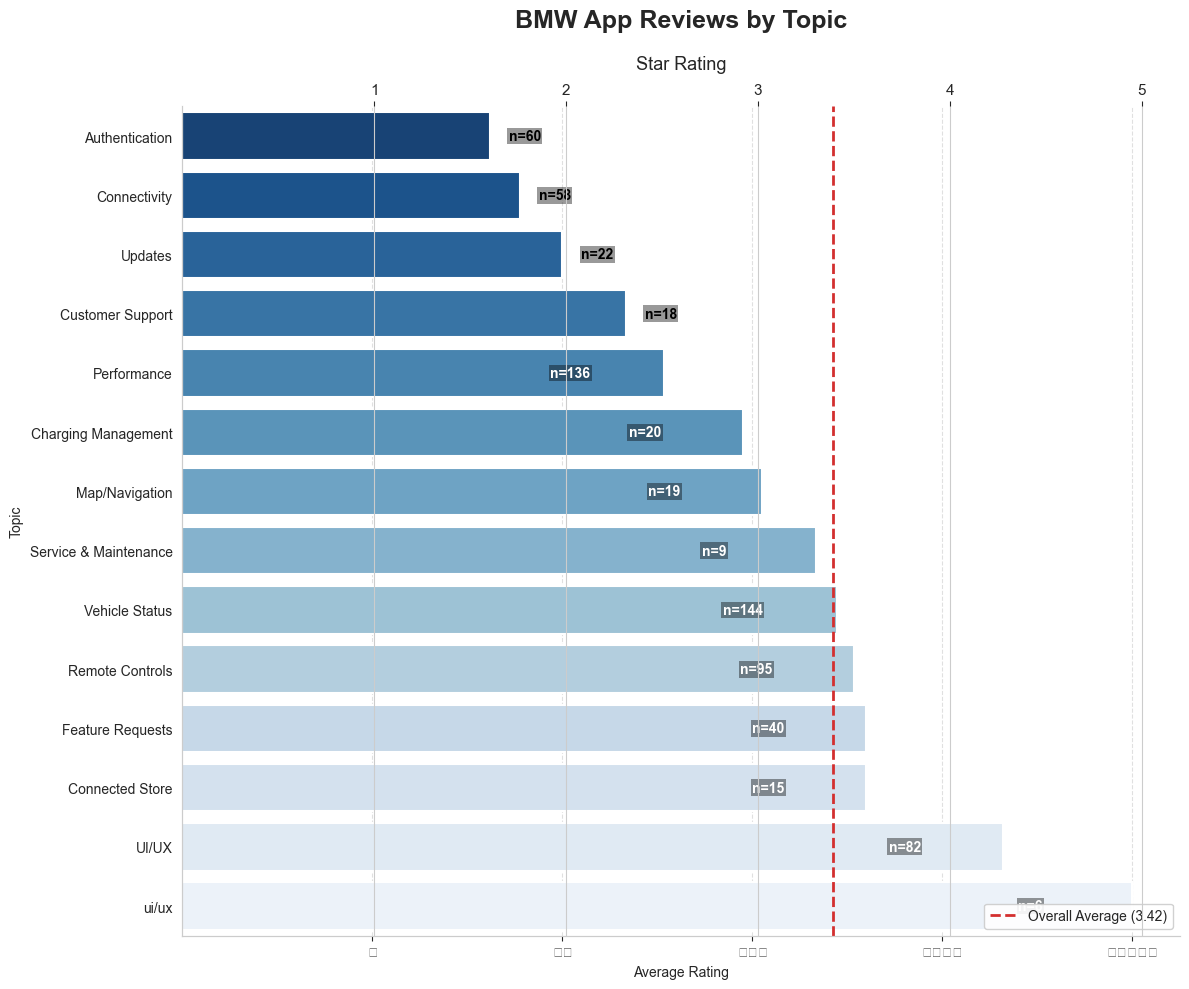

In [57]:
topic_summaries = create_topic_cards_from_df2(df2, ollama_model_name)